# midnite - Visualization Tutorial 1 - Part 2

in this notebook you will learn the intuition behind the features of the interpretability framework and how to us them.

## Layer Activation Mappings with AlexNet

Demonstration of visualizing layer attribution, the activation mapping  between two specified layers and their splits.

In [5]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2  
%cd ../src

import data_utils
from data_utils import DataConfig
from model_utils import Flatten
import plot_utils
from PIL import Image
from midnite import get_device
from midnite.visualization import SaliencyMap
from midnite.visualization import GuidedBackpropagation
from midnite.visualization import SpatialSplit
from midnite.visualization import ChannelSplit
from midnite.visualization import NeuronSplit
from midnite.visualization import NeuronSelector

import torch
from torch import Tensor
from torch.nn import Softmax
from torch.nn.functional import interpolate
from torchvision import models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/christina/Development/interpretability-framework/src


## Step 1: Load pretrained model

In our example we use a pretrained ResNet for demonstration.

In [6]:
model = models.alexnet(pretrained=True)

model.eval()
model.to(get_device());

## Step 2: Load Image

In [7]:
# in distribution example
img_path = "../data/imagenet_example_283.jpg"
# out of distribution example
#img_path = "../data/ood_example.jpg"

# load image as torch tensor for computation
input_ = data_utils.get_example_from_path(img_path, DataConfig.ALEX_NET)

# load image as PIL Image for plotting and resizing
img = Image.open(img_path)
H, W = img.size

## Layer attribution mapping
<img src="resources/saliencies_gradCAM.png">

## Step 3: Select Layer of Interest

in AlexNet there are 3 main layers (feature, avgpool and classification). For visualization we are interested in the feature layers, which consist of 13 layers. 
**Note: choose layers between 0 and 12 for AlexNet**

for example: we select layer number 6 as single layer (selected_layer) and want to compute its attribution to layer number 10 (output_layer).

In [14]:
selected_input_layer = 6
selected_output_layer = 10

### Split the Model into base_layers and inspection_layers
splitting the model with classification returns a list of base layers up to the selected single layer and the list of layers (inspection layers) from the selected layer until the specified output layer.

In [30]:
base_layers = list(model.features.children())[:selected_input_layer]
inspection_layers = list(model.features.children())[selected_input_layer:selected_output_layer+1]

## Step 4: Specify Layer Selectors
in this example we want to analyze the attribution of the selected layer 6 to layer 10. In other words, we want to know how much the features of layer 6 contributed to the output of layer 10, or more precisely, how much the they contributed to the top-layer-selection of layer 10.

For the inspection of a neuron value in the output, we use a top-layer-selector choosing the neuron of choice from a Neuronsplit of the output.

Additionally, a bottom_layer_split can be chosen. A SpatialSplit() gives the activations for each spatial position, which can be interpolated to the original image size and hence, be plotted onto the image. A NeuronSplit() as bottom_laye

**!!Please Note: 
the bottom_layer_selector needs to be an appropriate split for the selected_input_layer, 
and top_layer_selector needs to be an appropriate split for the selected_output_layer.**

In [31]:
top_layer_selector = NeuronSelector(NeuronSplit(), [0, 0, 0])
bottom_layer_split = SpatialSplit()

## Step 5: Compute Saliency

### bottom layer SpacialSplit with top layer NeuronSelector
Computing the saliency for the first neuron of layer 6 (NeuronSplit [0, 0, 0]) with respect to the spatial dimensions of layer 10 (SpatialSplit). We can see that this neuron detects the right eye of the cat.

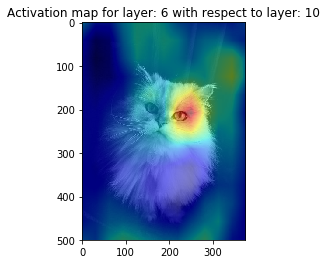

In [32]:
saliency_map = SaliencyMap(
    inspection_layers,
    top_layer_selector,
    base_layers,
    bottom_layer_split
)

saliency = saliency_map.visualize(input_)

# upsample saliency to the pixel dimensions of the image
# !interpolate needs 4 dim input
sal_map = interpolate(
    saliency.unsqueeze(dim=0).unsqueeze(dim=0), 
    size=(H, W), 
    mode='bilinear', 
    align_corners=True
)

# plot saliencies with the input image
plot_utils.plot_saliency(sal_map, img, selected_input_layer, selected_output_layer)

## Example 2 : Top-layer channel attribution with bottom-layer spatial split (Steps 3-6)
which activations did layer 3 have w.r.t. to channel 0 of layer 12?

In [75]:
# select splits of interest
top_layer_selector = NeuronSelector(ChannelSplit(), [0])
bottom_layer_split = SpatialSplit()

# split model into base_layers and inspection layers
base_layers = list(model.features.children())[:3]
inspection_layers = list(model.features.children())[3: 13] #slice indexing is [i: j-1]

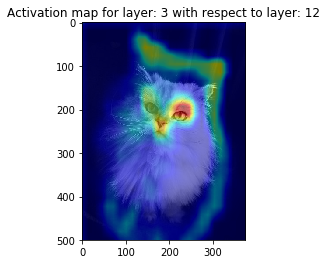

In [76]:
# init saliency map object
saliency_map = SaliencyMap(
    inspection_layers, 
    top_layer_selector, 
    base_layers, 
    bottom_layer_split
)

# compute saliency
saliency = saliency_map.visualize(input_)
        
# upsample saliency to the pixel dimensions of the image
sal_map = interpolate(
    saliency.unsqueeze(dim=0).unsqueeze(dim=0),
    size=(H, W), 
    mode='bilinear', 
    align_corners=True
)
        
# plot saliencies with the input image
plot_utils.plot_saliency(sal_map, img, 3, 12)

## Example 3 : How to gain insight from bottom-layer-splits (Steps 3-6)
Here we investigate the activations of layer 6 with respect to the first neuron in layer 10.

### 1) bottom-layer channel split 
First, a channel split of the bottom-layer should reveal the most activated channels for this output neuron.

In [150]:
# select layers of interest and split model into base_layers and inspection layers
base_layers = list(model.features.children())[:6]
inspection_layers = list(model.features.children())[6: 11] #slice indexing is [i: j-1]

# select splits of interest
top_layer_selector = NeuronSelector(NeuronSplit(), [0, 0, 0])
bottom_layer_split = ChannelSplit()

In [151]:
saliency_map = SaliencyMap(
    inspection_layers, 
    top_layer_selector, 
    base_layers, 
    bottom_layer_split
)

saliency = saliency_map.visualize(input_)

top_values, top_channels = torch.topk(saliency, 5)

for (value, idx) in zip(top_values, top_channels):
    print("Channel number: {} with channel value: {}".format(idx, value))

Channel number: 7 with channel value: 5.4257387915868094e-08
Channel number: 149 with channel value: 5.376769252052327e-08
Channel number: 18 with channel value: 3.4214853172898074e-08
Channel number: 173 with channel value: 3.4096736101218994e-08
Channel number: 32 with channel value: 3.135557236078057e-08


### 2) bottom-layer neuron split
Now let's look into these channels in greater detail and retrieve a neuron split on layer 6 and select one of the above max channels. Here we use the most active channel: #7.

In [160]:
# new bottom layer split, as we now want to retrieve the neuron activations with fixed channel 7
bottom_layer_split = NeuronSplit()

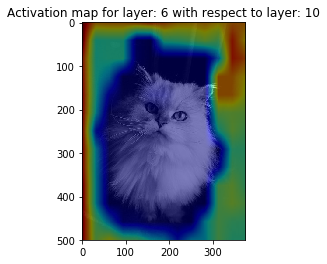

In [161]:
saliency = SaliencyMap(
    inspection_layers, 
    top_layer_selector, 
    base_layers, 
    bottom_layer_split
).visualize(input_)

# visualize the neurons of channel 7
# upsample saliency to the pixel dimensions of the image
sal_map = interpolate(
    saliency[7].unsqueeze(dim=0).unsqueeze(dim=0),
    size=(H, W),
    mode='bilinear', 
    align_corners=True
)

# plot saliencies neuron activations
plot_utils.plot_saliency(sal_map, img, 6, 10)

## Example 4: Guided Backpropagation of the input image w.r.t. the class score

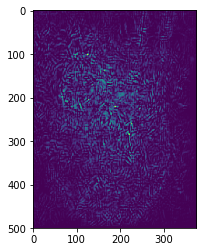

In [157]:
layers = list(model.features.children()) + [Flatten()] + list(model.classifier.children())

saliency = GuidedBackpropagation(
    layers, 
    NeuronSelector(NeuronSplit(), [283]), 
    SpatialSplit()
).visualize(input_)

# plot saliencies with the input image
plot_utils.plot_guided_backprop(saliency, img)